We are interested in the swarm passes over our event. To do this we need to:

A: Plot the Images

B: Get the emphermis data for swarm B

C: Find the footprint of swarm B at the assumed emission height of 110km

D: Overplot the emphermis data with the ground based observations

Lets first grab our images from the package asilib

Lets choose a 3x2 grid to plot the images, our images will start at 14:04.20 and then move 10 seconds

In [360]:
import numpy as np #Lets handle our imports now for section A
import matplotlib.pyplot as plt
import asilib
import asilib.asi
from datetime import datetime, timedelta
from scipy.optimize import curve_fit


In [361]:
start_time= datetime(2022,12,19,14,4,20)
time_array= [start_time + timedelta(seconds=10*x) for x in range(6)]
alt=110

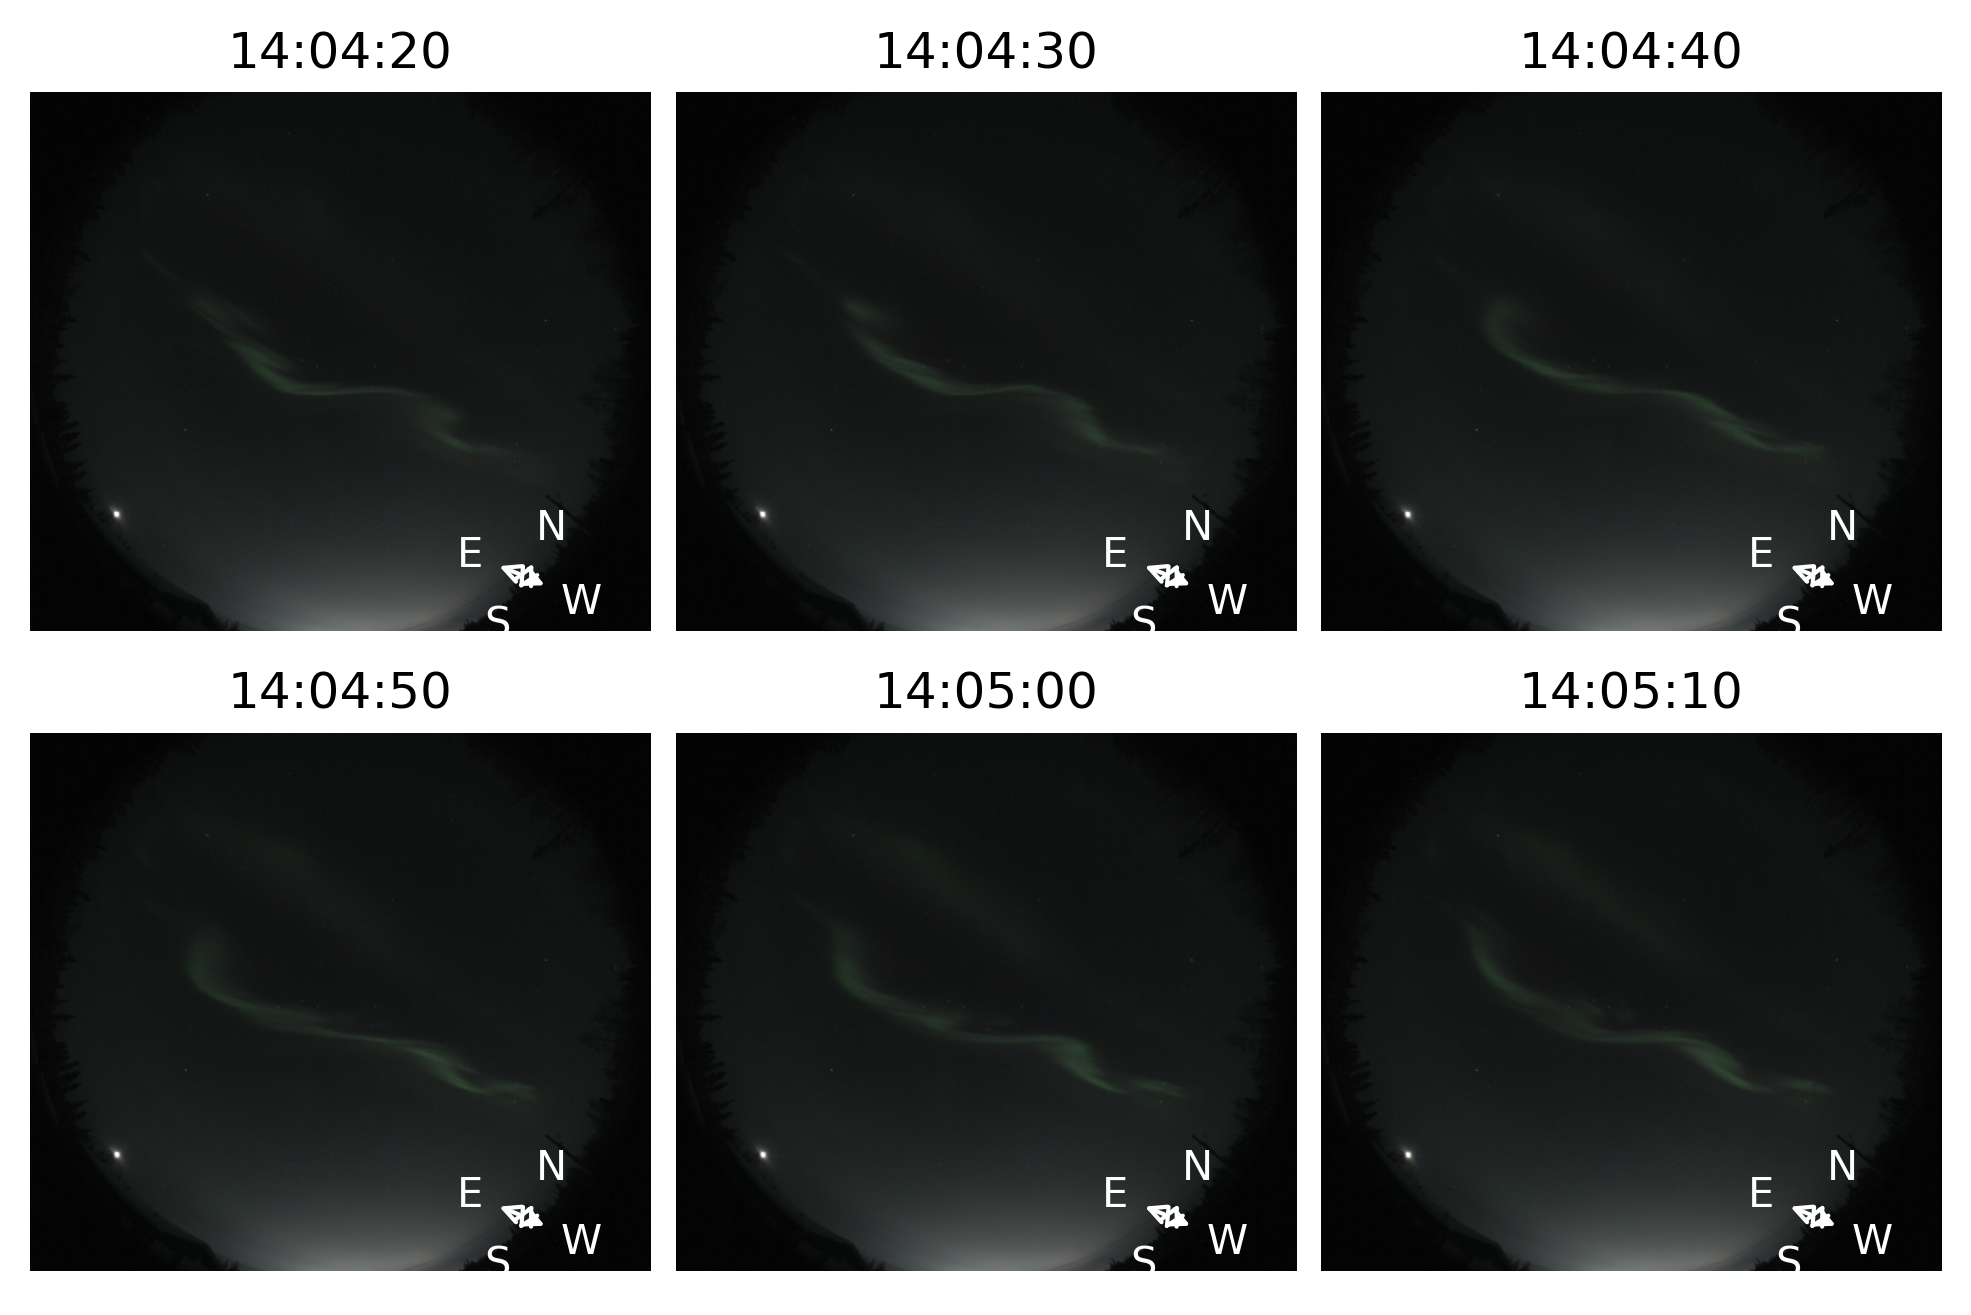

In [362]:
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=300)
axlist=axes.flatten()
plt.axis('off')

for i in range(len(time_array)):
    asi=asilib.asi.trex_rgb(location_code='yknf', alt=alt, time=time_array[i])

    asi.plot_fisheye(ax=axlist[i], label=False, cardinal_directions='NEWS')
    axlist[i].set_axis_off()
    axlist[i].set_title(time_array[i].strftime('%H:%M:%S%f')[:-6])
plt.tight_layout(pad=0.1, w_pad=0.6, h_pad=-2.5)
plt.savefig("test.png",bbox_inches='tight')

Now lets move onto part B

We are going to use the viresclient ESA client to download swarm empharmsis data with a frequency that matches the cadence of 3 so that it matches with the cadence of trex rgb.

In [363]:
from viresclient import set_token
from viresclient import SwarmRequest
import geopack.geopack as gp



In [364]:
#Now we need to set our token, for my case to protect my token I import from a file not in the github cloud, however you can just paste your code from viresclient, just don't share it publically!


In [365]:
#From documentation link
def requester(sc_collection, measurement, residual, sampling_step=None, **kwargs):
    try:
        request = SwarmRequest()
        request.set_collection(sc_collection)
        if residual == True:
            request.set_products(
                measurements=measurement,
                models=["CHAOS"],
                residuals=True,
                sampling_step=sampling_step,
            )
        else:
            request.set_products(
                measurements=measurement,
                models=["CHAOS"],
                sampling_step=sampling_step,
            )
        data = request.get_between(time_array[0], time_array[-1]+timedelta(seconds=10), **kwargs) #sets to get data between the first and last value in time array iniatialized earlier
        df = data.as_dataframe()
    except:
        df = []
    return df

In [366]:
ds = requester( 
    "SW_OPER_MAGB_LR_1B", #Mag B, low resolution, 1Hz B (Magnetic field)
    "B_NEC", #Magnetic field in NEC coordinates
    True, 
    asynchronous=False,
    show_progress=False,
    sampling_step="PT{}S".format(10)) #cadence of 10 to match our images, in practice this selects every 10th data point since the resolution is 1 sample a second (sps)



In [367]:
latitude, longitude, altitude = ds['Latitude'].to_numpy(), ds['Longitude'].to_numpy(),  (ds["Radius"].to_numpy()-6.371e6)/1e3 #km  # Gets Emphermis data
print(ds.index)

DatetimeIndex(['2022-12-19 14:04:20', '2022-12-19 14:04:30',
               '2022-12-19 14:04:40', '2022-12-19 14:04:50',
               '2022-12-19 14:05:00', '2022-12-19 14:05:10'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)


Good now that we have empharsis we need to find the footprint. To do this, we use geopack and asilib. Alternatively if you have IRBEM installed you can use asilib.conjunction.footprint to do this automagically.

In [368]:
t1 = time_array[0]
t0 = datetime(1970,1,1)
ut = (t1-t0).total_seconds()
lat_sat=np.deg2rad(latitude)
lon_sat=np.deg2rad(longitude)
gp.recalc(ut)
print(altitude)
r, theta= gp.geodgeo(altitude,lat_sat,1) #TODO magically, r is 10km less than if you calculated r manually, is this real

x_gc,y_gc,z_gc = gp.sphcar((r)/6371,theta,lon_sat,1)  #spherical to cartesian
 

x_gsm, y_gsm, z_gsm = gp.geogsm(x_gc,y_gc,z_gc, 1) #cartesian to gsm

x_foot,y_foot,z_foot=np.zeros(len(x_gsm)), np.zeros(len(y_gsm)), np.zeros(len(z_gsm)) #initalize an array


[501.38629 501.46233 501.53985 501.61884 501.69928 501.78114]


In [369]:
for index in range(len(x_gsm)):
    x_foot_int, y_foot_int, z_foot_int, xx, _,zz = gp.trace(x_gsm[index], y_gsm[index], z_gsm[index], dir=1,rlim=2, r0=(alt-10+6371)/6371, maxloop=300 ) #traces each set of lat,lon,alt outward
    _, _, _, xx2,yy2,zz2 = gp.trace(x_foot_int, y_foot_int, z_foot_int, dir=-1,rlim=100, r0=(alt-10+6371)/6371, maxloop=1000 )#Traces inward
    def curve_fit_func():
        def cubic(t, a, b, c, d):
            return a*t**3 + b*t**2 + c*t + d
        r = np.linspace(1, 1.5, 100000)

        radius_data=np.sqrt(xx2**2+yy2**2+zz2**2)

        params_x, _ = curve_fit(cubic, radius_data, xx2) #Constructs fits on the traces inward since the spatial resolution produced by geopack is limited.
        params_y, _ = curve_fit(cubic, radius_data, yy2)
        params_z, _ = curve_fit(cubic, radius_data, zz2)

        def x(t):
            return cubic(t, *params_x)

        def y(t):
            return cubic(t, *params_y)

        def z(t):
            return cubic(t, *params_z)
        def radius(t):
            return np.sqrt(x(t)**2 + y(t)**2 + z(t)**2)

        index_closest=np.argmin(np.abs(radius(r)-(alt-10+6371)/6371))

        return x(r[index_closest]),y(r[index_closest]),z(r[index_closest])

    x_foot[index],y_foot[index],z_foot[index] = curve_fit_func()

x_done, y_done, z_done = gp.geogsm(x_foot, y_foot, z_foot, -1)

alt_sat_done, lat_sat_done,lon_sat_done = np.zeros(len(x_done)), np.zeros(len(x_done)), np.zeros(len(x_done))
for index in range(len(x_done)):
    
    r_done,theta_done,lon_sat_done[index]= gp.sphcar(x_done[index], y_done[index], z_done[index],-1)

    alt_sat_done[index], lat_sat_done[index]= gp.geodgeo(r_done*6371,theta_done,-1) #TODO check if this is right

print(alt_sat_done, 'altitude derived from fit')

if np.any(np.abs(alt_sat_done - alt) > 5):
    raise Exception("One or more values in the footprinting are greater than 5km away from the specified alt. Contact owner for a fix, not your fault")
print(np.rad2deg(lon_sat_done)-360,np.rad2deg(lat_sat_done) , 'lat and lon' )
sat_lla=np.array([np.rad2deg(lat_sat_done), np.rad2deg(lon_sat_done)-360, alt_sat_done]).T

conjunction_obj = asilib.Conjunction(asi, (np.array(time_array), sat_lla))

[110.32061605 110.12663963 109.94338575 109.75734404 109.56862153
 109.37733192] altitude derived from fit
[-117.60976121 -117.52006103 -117.43615115 -117.3575425  -117.28387829
 -117.21483285] [64.66926741 64.05547769 63.44340418 62.831648   62.2202157  61.60911312] lat and lon


Now lets use asilib to synthsize the empharsis data with the images

In [370]:
sat_azel, sat_azel_pixels = conjunction_obj.map_azel()

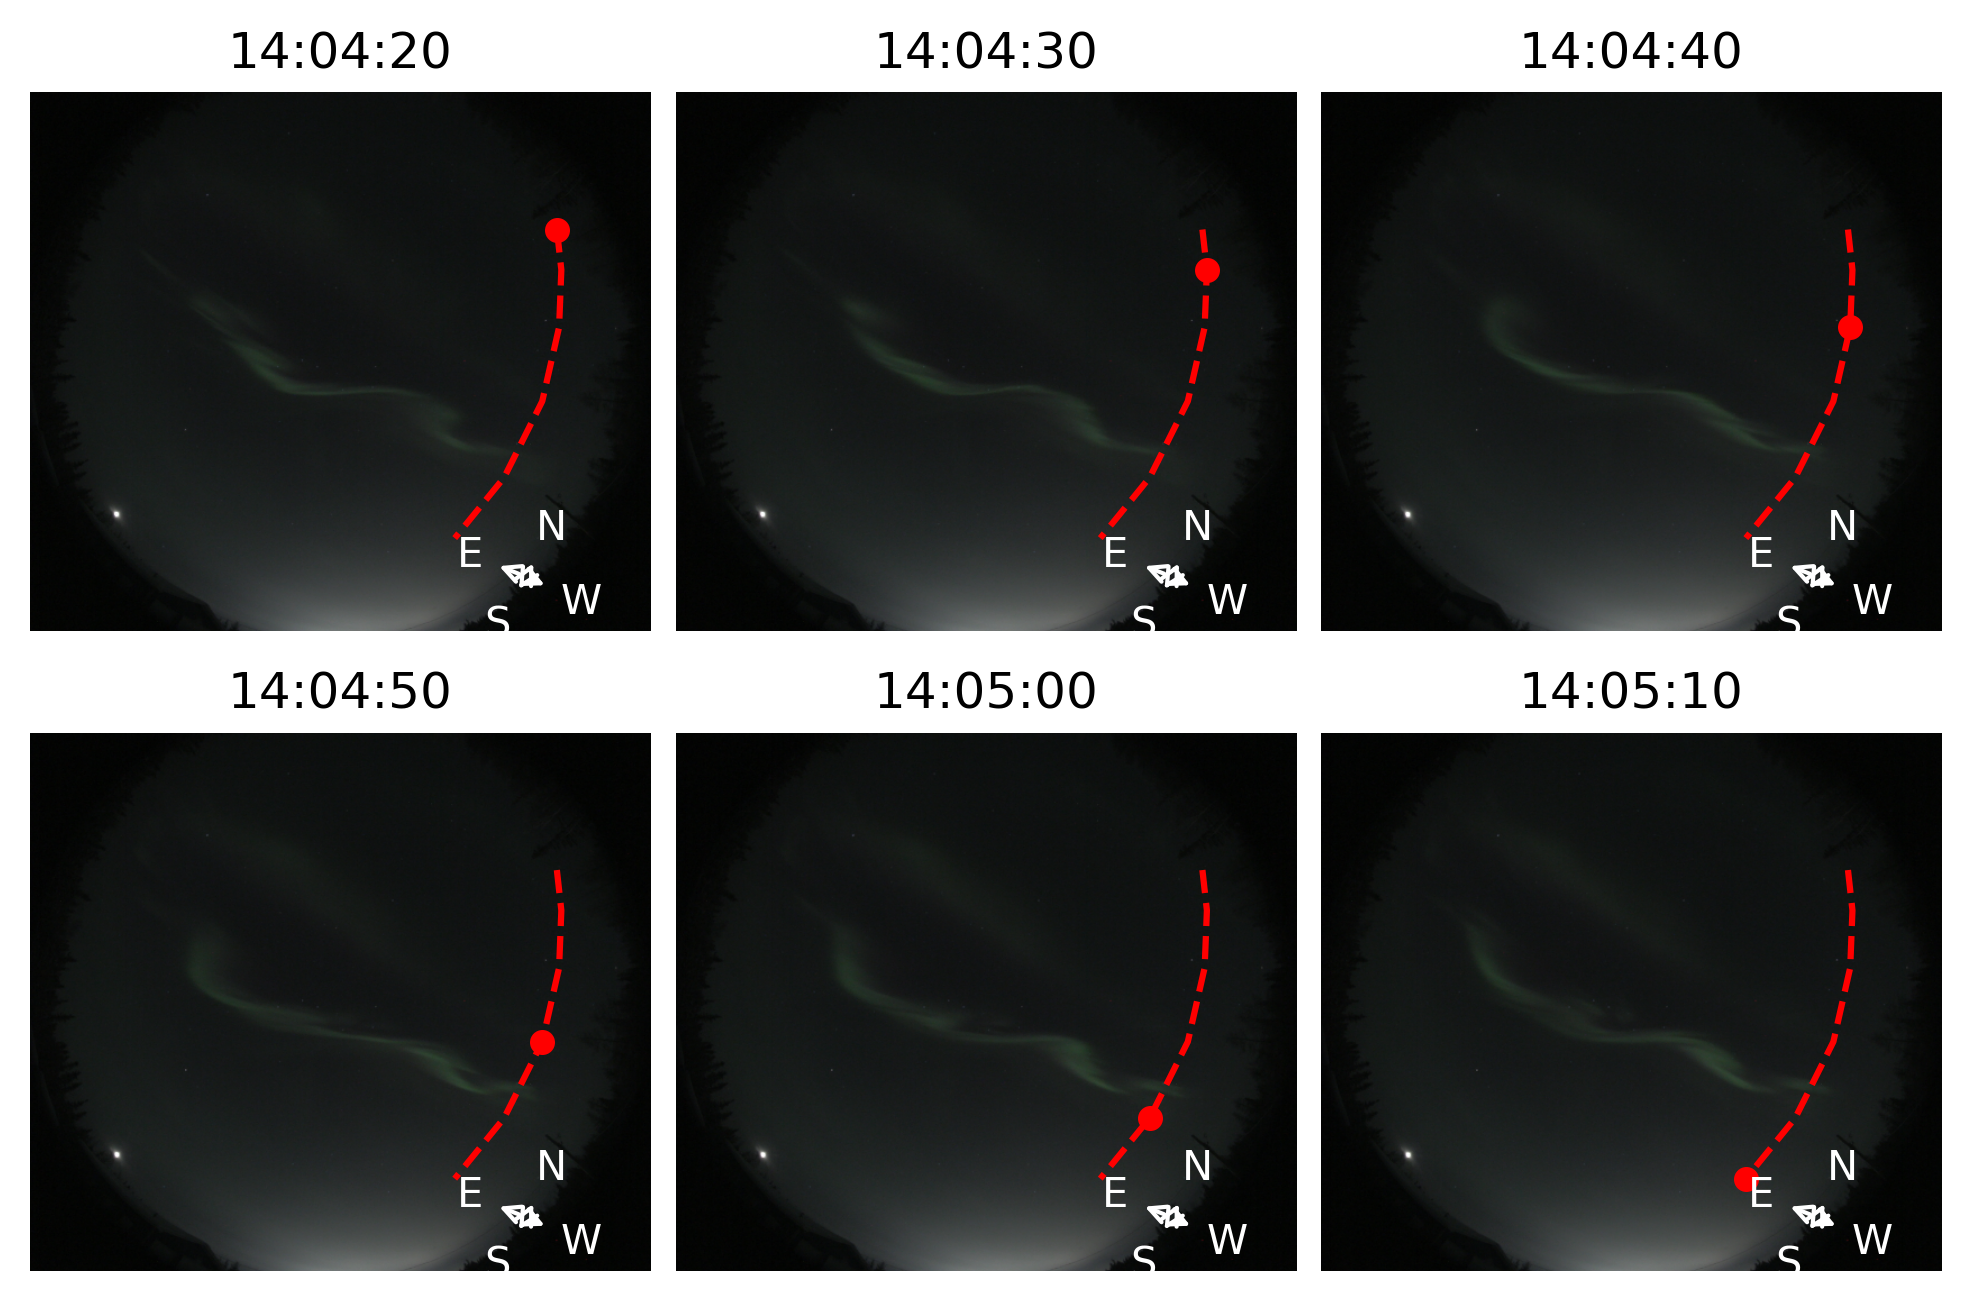

In [374]:
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=300)
axlist=axes.flatten()
plt.axis('off')

for i in range(len(time_array)):
    asi=asilib.asi.trex_rgb(location_code='yknf', alt=alt, time=time_array[i])

    asi.plot_fisheye(ax=axlist[i], label=False, cardinal_directions='NEWS')
    axlist[i].set_axis_off()
    axlist[i].set_title(time_array[i].strftime('%H:%M:%S%f')[:-6])
plt.tight_layout(pad=0.1, w_pad=0.6, h_pad=-2.5)
plt.savefig("test.png",bbox_inches='tight')
for i in range(len(axlist)):
    axlist[i].plot(sat_azel_pixels[:, 0],
                            sat_azel_pixels[:, 1], color='red', linestyle="dashed")
    axlist[i].scatter(sat_azel_pixels[i, 0], sat_azel_pixels[i, 1],
                marker='o', s=25, color='red')